# Linear regression baseline

In this notebook, we will create the linear regression baselines.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

## Load and prepare data for training

First up, we need to load and prepare the data so that we can feed it into our linear regression model.

In [5]:
DATADIR = '/data/weather-benchmark/5.625deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [6]:
# Load the entire dataset
z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t

In [7]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')

In [8]:
# Split into train and test data
z500_train = z500.sel(time=slice('1979', '2016'))
z500_test = z500.sel(time=slice('2017', '2018'))
t850_train = t850.sel(time=slice('1979', '2016'))
t850_test = t850.sel(time=slice('2017', '2018'))

In [9]:
# Compute normalization statistics
z500_mean = z500_train.mean().values
z500_std = z500_train.std('time').mean().values
t850_mean = t850_train.mean().values
t850_std = t850_train.std('time').mean().values

In [10]:
z500_mean, z500_std, t850_mean, t850_std

(array(54111.594, dtype=float32),
 array(1115.3833, dtype=float32),
 array(274.54495, dtype=float32),
 array(5.681409, dtype=float32))

In [11]:
# Normalize datasets
data_z500_train = (z500_train - z500_mean) / z500_std
data_z500_test = (z500_test - z500_mean) / z500_std
data_t850_train = (t850_train - t850_mean) / t850_std
data_t850_test = (t850_test - t850_mean) / t850_std

In [12]:
_, nlat, nlon = data_z500_train.shape; nlat, nlon

(32, 64)

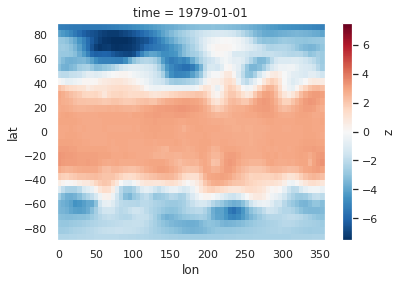

In [13]:
data_z500_train.isel(time=0).plot()

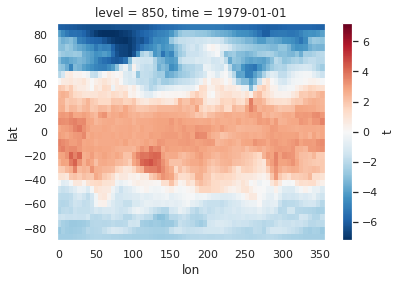

In [14]:
data_t850_train.isel(time=0).plot()

In [15]:
def create_training_data(data, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = data.isel(time=slice(0, -lead_time_h))
    y = data.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

## Train linear regression

Now let's train the model. We will use scikit-learn for this.

In [16]:
def train_lr(lead_time_h, vars=['z', 't']):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    if 'z' in vars:
        X, y = create_training_data(data_z500_train, lead_time_h)
        X_train.append(X); y_train.append(y)
        X, y, valid_time = create_training_data(data_z500_test, lead_time_h, return_valid_time=True)
        X_test.append(X); y_test.append(y)
    if 't' in vars:
        X, y = create_training_data(data_t850_train, lead_time_h)
        X_train.append(X); y_train.append(y)
        X, y, valid_time = create_training_data(data_t850_test, lead_time_h, return_valid_time=True)
        X_test.append(X); y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
        
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(vars):
        if v == 'z': data_mean = z500_mean; data_std = z500_std
        else: data_mean = t850_mean; data_std = t850_std
        fc = xr.DataArray(
            preds[:, i] * data_std + data_mean, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': z500.lat,
                'lon': z500.lon
            },
            name=v
        )
        fcs.append(fc)
    return fcs, lr   

### 3 days

Here we train a model to directly predict the fields at 3 days lead time. Let's train a model that only predicts z or t and then a combined model. As we can see below, the model trained only on Z500 performs better than the combined model. But the same is not the case for T850. For the paper, we will use the combined model.

In [13]:
# Train only with z
fc_3d, lr_3d = train_lr(3*24, vars=['z'])

Train MSE = 0.43062442541122437
Test MSE = 0.5234634280204773


In [18]:
compute_weighted_rmse(fc_3d[0], z500_valid).values

array(692.76963844)

In [22]:
# Train only with t
fc_3d, lr_3d = train_lr(3*24, vars=['t'])

Train MSE = 0.3241349160671234
Test MSE = 0.40045636892318726


In [25]:
compute_weighted_rmse(fc_3d[0], t850_valid).values

array(3.18926955)

In [30]:
# Train with z and t
(fc_z500_3d, fc_t850_3d), lr_3d = train_lr(3*24)

Train MSE = 0.31796592473983765
Test MSE = 0.48072150349617004


In [31]:
compute_weighted_rmse(fc_z500_3d, z500_valid).values

array(713.78158629)

In [32]:
compute_weighted_rmse(fc_t850_3d, t850_valid).values

array(3.18461606)

In [67]:
xr.Dataset({'z': fc_z500_3d, 't': fc_t850_3d}).to_netcdf(f'{PREDDIR}/fc_lr_3d.nc');
to_pickle(lr_3d, f'{PREDDIR}/saved_models/lr_3d.pkl')

### 5 days

Combined model for 5 days.

In [39]:
# Train with z and t
(fc_z500_5d, fc_t850_5d), lr_5d = train_lr(5*24)

Train MSE = 0.3933986723423004
Test MSE = 0.6094844341278076


In [40]:
compute_weighted_rmse(fc_z500_5d, z500_valid).values

array(813.53949079)

In [41]:
compute_weighted_rmse(fc_t850_5d, t850_valid).values

array(3.51787942)

In [68]:
xr.Dataset({'z': fc_z500_5d, 't': fc_t850_5d}).to_netcdf(f'{PREDDIR}/fc_lr_5d.nc');
to_pickle(lr_3d, f'{PREDDIR}/saved_models/lr_5d.pkl')

### Iterative forecast

Finally, an iterative forecast. First, we train a model for 6 hours lead time and then construct an iterative forecast up to 120 hours.

In [17]:
_, lr_6h = train_lr(6)

Train MSE = 0.027540646493434906
Test MSE = 0.03457337245345116


In [18]:
to_pickle(lr_6h, f'{PREDDIR}/saved_models/lr_6h.pkl')

In [19]:
data_z500_test

<xarray.DataArray 'z' (time: 17520, lat: 32, lon: 64)>
dask.array<truediv, shape=(17520, 32, 64), dtype=float32, chunksize=(8760, 32, 64)>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00

In [20]:
state = np.concatenate([data_z500_test.values.reshape(-1, nlat*nlon), 
                        data_t850_test.values.reshape(-1, nlat*nlon)], 1)

In [21]:
state.shape

(17520, 4096)

In [22]:
def create_iterative_fc(state, model, lead_time_h=6, max_lead_time_h=5*24):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs_z500, fcs_t850 = [], []
    for fc_step in range(max_fc_steps):
        state = model.predict(state)
        fc_z500 = state[:, :nlat*nlon].copy() * z500_std + z500_mean
        fc_t850 = state[:, nlat*nlon:].copy() * t850_std + t850_mean
        fc_z500 = fc_z500.reshape((-1, nlat, nlon))
        fc_t850 = fc_t850.reshape((-1, nlat, nlon))
        fcs_z500.append(fc_z500); fcs_t850.append(fc_t850)

    return [xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': data_z500_test.time,
            'lat': data_z500_test.lat,
            'lon': data_z500_test.lon
        }
    ) for fcs in [fcs_z500, fcs_t850]]

In [23]:
fc_z500_6h_iter, fc_t850_6h_iter = create_iterative_fc(state, lr_6h)

In [25]:
xr.Dataset({'z': fc_z500_6h_iter, 't': fc_t850_6h_iter}).to_netcdf(f'{PREDDIR}/fc_lr_6h_iter.nc');

In [26]:
rmses_z500_6h_iter = evaluate_iterative_forecast(fc_z500_6h_iter, z500_valid)
rmses_t850_6h_iter = evaluate_iterative_forecast(fc_t850_6h_iter, t850_valid)

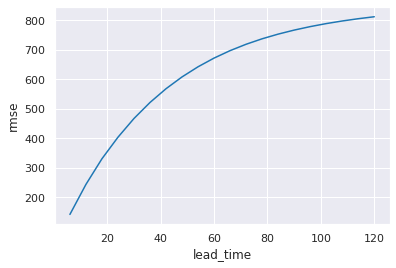

In [27]:
rmses_z500_6h_iter.plot();

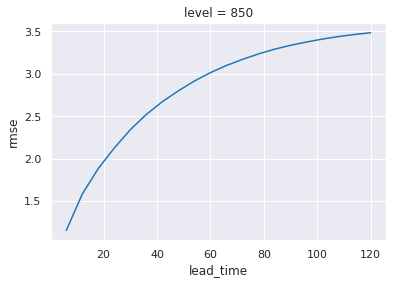

In [28]:
rmses_t850_6h_iter.plot();

In [29]:
rmses_z500_6h_iter.sel(lead_time=[3*24, 5*24])

<xarray.DataArray 'rmse' (lead_time: 2)>
dask.array<getitem, shape=(2,), dtype=float64, chunksize=(1,)>
Coordinates:
  * lead_time  (lead_time) int64 72 120

In [30]:
rmses_t850_6h_iter.sel(lead_time=[3*24, 5*24])

<xarray.DataArray 'rmse' (lead_time: 2)>
dask.array<getitem, shape=(2,), dtype=float64, chunksize=(1,)>
Coordinates:
    level      int32 850
  * lead_time  (lead_time) int64 72 120

# The End